<a href="https://colab.research.google.com/github/M-H-Amini/AI-Enabled-Software-Verification-and-Testing/blob/master/queens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Eight Queens Problem
#  AI-Enabled Software Verification and Testing (CSI 5137B - Fall 2022)
#  Professor: Shiva Nejati
##  Written By: Mohammad Hossein Amini (mh.amini@uottawa.ca)

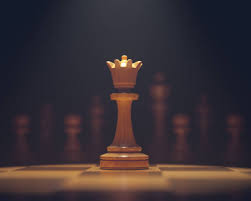

This notebook is created after the second lecture of the course on 9/25/2022. I've implemented it out of curiosity to see how the discussed ideas work in practice. It might be helpful for anyone who wish to gain some insight into search-based optimization. I may implement other methods to solve this problem as the course goes on. Special thanks to my professor, Shiva Nejati.

#  Board Class

Here, I've implemented the board class to be able to work easily with each board. It has the following methods.


-  ```placeQueen```: This function gets a row i, and a column j. It places a queen in that coordinates.

- ```removeQueen```: This function gets a row i, and a column j. It removes the queen in that coordinates.

- ```queensCoordinates```: This function returns coordinates of all the queens on the board as a list of tuples.

-  ```checkPosition```: This function gets a row i, and a column j. It finds number of threatens the (i,j) square is receiving in the board. Clearly for a queen in position (i,j), if this function returns 0, it means the queen is safe. And if the queen is threatened by 3 other queens, the function returns 3.

- ```checkBoard```: This function sums all number of threatens of all the queens of the board. Clearly, a safe board has 0 returned by this function. The less queens being threatend, the less the returned value. We would use this function as the **fitness function**.

-  ```possibleMoves```: This function gets a row i, and a column j. It returns the neighbouring empty squares around square (i,j) as a list of tuples. We would use this function to find out how we can create a new board from a previous board (**mutation**).


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from random import choice, sample

class Board:
  def __init__(self, board=None):
    self.board = np.zeros((8, 8)) if board is None else board

  def checkPosition(self, i, j):
    cnt = 0
    diag_main = i - j
    diag_red = i + j
    for k in range(8):
      if self.board[k][j] and k != i:
        cnt += 1
      if self.board[i][k] and k != j:
        cnt += 1
      if 0 <= k - diag_main <= 7 and self.board[k][k - diag_main] and k != i:
        cnt += 1
      if 0 <= diag_red - k <= 7 and self.board[k][diag_red - k] and k != i:
        cnt += 1

    return cnt
  
  def placeQueen(self, i, j):
    self.board[i, j] = 1
  
  def removeQueen(self, i, j):
    self.board[i, j] = 0

  def queensCoordinates(self):
    return list(zip(*np.where(self.board == 1)))

  def checkBoard(self):    
    queens = self.queensCoordinates()
    cnt = 0
    for coord in queens:
      cnt += self.checkPosition(*coord)
    return cnt
  
  def possibleMoves(self, i, j):
    row_low, row_high = max(0, i-1), min(8, i+2)
    col_low, col_high = max(0, j-1), min(8, j+2)
    candidates = list(product(range(row_low, row_high), range(col_low, col_high)))
    candidates = [candidate for candidate in candidates if not self.board[candidate]]
    return candidates

  def copy(self):
    new_board = Board(self.board.copy())
    return new_board
  
  def __eq__(self, a):
    return np.all(self.board == a.board)

  def __hash__(self):
    return int(''.join(map(lambda x: str(x), self.board.astype(int).flatten().tolist())))

  def show(self):
    print(self.board)
    return self

  def render(self):
    temp_board = np.zeros((8,8))
    for i in range(8):
      for j in range(8):
        if (i + j) % 2:
          temp_board[i, j] = 1
    queens = self.queensCoordinates()
    figure, axes = plt.subplots()
    axes.matshow(temp_board, cmap='gray')
    
    for (i, j) in queens:
      circle = plt.Circle(( j , i ), 0.4, color='red')
      axes.add_artist(circle)
    
    axes.set_xticklabels([chr(64 + i) for i in range(9)])
    axes.set_yticklabels(range(9, 0, -1))
    plt.show()
    return self
  

Let's see a sample usage of the ```Board``` class.

Queens coordinates: [(0, 0), (1, 3), (5, 7), (6, 5), (6, 7)]
Number of threatens of all queens: 6
Possible moves from square (0,0):  [(0, 1), (1, 0), (1, 1)]
Possible moves from square (1,3):  [(0, 2), (0, 3), (0, 4), (1, 2), (1, 4), (2, 2), (2, 3), (2, 4)]
Possible moves from square (5,7):  [(4, 6), (4, 7), (5, 6), (6, 6)]


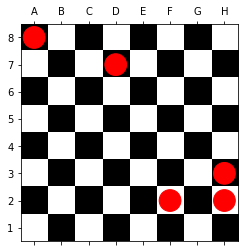

In [94]:
board = Board()

board.placeQueen(0,0)
board.placeQueen(6,5)
board.placeQueen(1,3)
board.placeQueen(5,7)
board.placeQueen(6,7)

print('Queens coordinates:', board.queensCoordinates())
print('Number of threatens of all queens:', board.checkBoard())
print('Possible moves from square (0,0): ', board.possibleMoves(0,0))
print('Possible moves from square (1,3): ', board.possibleMoves(1,3))
print('Possible moves from square (5,7): ', board.possibleMoves(5,7))
board.render();

#  Backtracking

In this method, we try to solve the problem sequentially. As we know there should be only 1 queen in each column of the board. So, we can start from column number 1 and place a queen in one of its available squares, and go on to the next column and so on. In this process one of the two cases would occur:

-  We would reach to column number 8 and have 8 safe queens
-  While placing queens in columns sequentially, we reach to a state in which we haven't placed 8 queens yet, but the last queen placed is already in danger.

First case is obviously a solution to the problem. However, in second case, we would **backtrack** the last move and place that queen in another square.

This method is implemented in a recursive fashion with the ```backtracking``` function. It takes a board and column number i, in which we must place a new queen there. It also gets a list of solutions to keep track of. Passing verbose as 1, shows some information during the process.

In [ ]:
no_of_boards = 0

def backtracking(board, i, solutions, verbose=0):
  global no_of_boards
  if not board.checkBoard() and i == 8:
    solutions.append(board)
    if verbose:
      print('A solution found!')
      board.render()
    return solutions
  
  for j in range(8):
    new_board = board.copy()
    new_board.placeQueen(i, j)
    no_of_boards += 1
    if not new_board.checkBoard():
      solutions = backtracking(new_board, i+1, solutions, verbose)
    
  return solutions

Now, the problem can be solved easily.

In [ ]:
solutions = []
board = Board()
solutions = backtracking(board, 0, solutions)
print('No of solutions: ', len(solutions))
print('No of boards processed: ', no_of_boards)

No of solutions:  92
No of boards processed:  15720


Let's see some solutions.

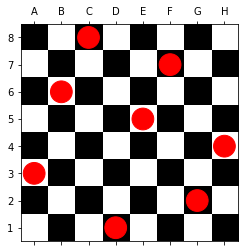

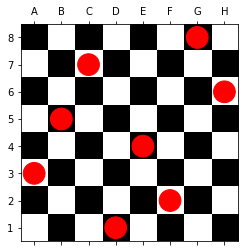

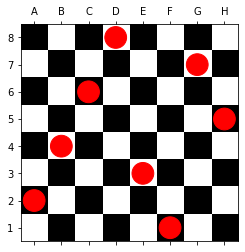

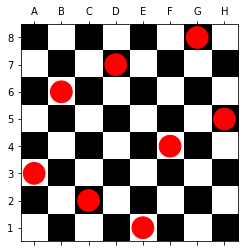

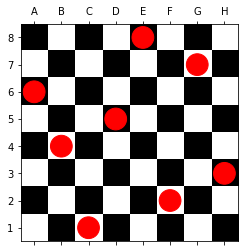

In [ ]:
for i in range(5):
  choice(solutions).render()

#  Genetic Algorithm
In this method, rather than placing queens sequentially, we initialize the board with 8 queens placed completely randomly.

In [ ]:
def initialize():
  board = Board()
  queens = sample(list(product(range(8), repeat=2)), 8)
  [board.placeQueen(i, j) for i,j in queens]
  return board

Let's see how the ```initialize``` function works.

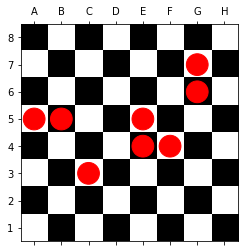

In [ ]:
board = initialize().render()

The mutation process is implemented as the ```generateNewBoardsFromBoard``` function which gets a board and generates some new boards out of it.

In [ ]:
def generateNewBoardsFromBoard(board, n=4):
  new_boards = []
  queens = board.queensCoordinates()
  for i in range(n):
    new_board = board.copy()
    queen = choice(queens)
    possible_moves = board.possibleMoves(*queen)
    move = choice(possible_moves)
    new_board.removeQueen(*queen)
    new_board.placeQueen(*move)
    new_boards.append(new_board)
  return new_boards

The fitness function for a board is defined as number of all threatens of that board's queens. The main solver is implemented in the ```evolve``` function. It gets an inital population and generates m new boards from each of the instances. After that a certain rate of the new and old populations, based on their fitness values, are survived and passed to the next generation.

In [ ]:
no_of_boards = 0

def evolve(boards_list, solutions_list, m=4, survive_rate=0.4, generation_no=0, max_generations=5):
  global no_of_boards
  if generation_no >= max_generations:
    return boards_list, solutions_list
  print('-'*20,f'Generation {generation_no}', '-' * 20)
  print(f'No of boards: {len(boards_list)}')
  print(f'No of solutions: {len(solutions_list)}')
  candidates = []
  [candidates.extend(generateNewBoardsFromBoard(board, m)) for board in boards_list]
  candidates = boards_list + candidates
  no_of_boards += len(candidates)
  no_of_survives = int(len(candidates) * survive_rate)
  print(f'No of candidates: {len(candidates)}')
  scores = [board.checkBoard() for board in candidates]
  solutions_list.extend([candidates[i] for i in range(len(candidates)) if not scores[i]])
  print(f'Scores: {scores}')
  print(f'No of survives: {no_of_survives}')
  new_generation = [candidates[i] for i in np.argsort(scores)[:no_of_survives]]
  scores = [board.checkBoard() for board in new_generation]
  print(f'Survives scores: {scores}')
  boards_list, solutions_list = evolve(new_generation, solutions_list, m, survive_rate, generation_no+1, max_generations)
  return boards_list, solutions_list

Problem solving is as simple of a single line now!

In [ ]:
boards_list = [initialize() for i in range(5)]  ##  Initial population
solutions_list = []
boards_list, solutions_list = evolve(boards_list, solutions_list, survive_rate=0.3, max_generations=18)
print(f'Found {len(solutions_list)} solutions!')

-------------------- Generation 0 --------------------
No of boards: 5
No of solutions: 0
No of candidates: 25
Scores: [22, 16, 18, 16, 18, 30, 24, 20, 22, 16, 20, 18, 18, 16, 22, 20, 24, 20, 18, 18, 16, 18, 18, 16, 20]
No of survives: 7
Survives scores: [16, 16, 16, 16, 16, 16, 18]
-------------------- Generation 1 --------------------
No of boards: 7
No of solutions: 0
No of candidates: 35
Scores: [16, 16, 16, 16, 16, 16, 18, 20, 12, 22, 22, 12, 18, 16, 16, 20, 18, 22, 18, 14, 16, 16, 20, 16, 14, 22, 18, 18, 16, 16, 20, 20, 18, 20, 18]
No of survives: 10
Survives scores: [12, 12, 14, 14, 16, 16, 16, 16, 16, 16]
-------------------- Generation 2 --------------------
No of boards: 10
No of solutions: 0
No of candidates: 50
Scores: [12, 12, 14, 14, 16, 16, 16, 16, 16, 16, 12, 12, 12, 12, 18, 18, 14, 16, 16, 18, 18, 18, 14, 18, 14, 12, 16, 16, 16, 16, 14, 20, 22, 14, 14, 16, 18, 20, 12, 16, 16, 18, 20, 20, 12, 20, 14, 18, 16, 18]
No of survives: 15
Survives scores: [12, 12, 12, 12, 12, 1

In [ ]:
print(f'No of boards processed: {no_of_boards}')

No of boards processed: 62465


However, there may be duplicate answers in the ```solutions_list``` due to the nature of this method. So let's remove the duplicates.

In [ ]:
solutions_list = list(set(solutions_list))
print(f'No of unique solutions: {len(solutions_list)}')

No of unique solutions: 1


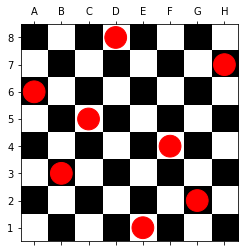

In [ ]:
for board in solutions_list:
  board.render()

#  Discussion
As can be seen, this implementation of the backtracking algorithm had way less boards processed (15720) compared to this implementation of the genetic algorithm (62465 in a sample run). It makes it more fun to know that the backtracking was able to find **all** the solutions (92), while the genetic algorithm found just 1 solution in all those processes. In my opinion, this is because we've used a way more powerful heuristic in the backtracking than in the genetic algorithm. In other words, we chose to just place one queen in each column in backtracking since we know the chess rules. However, we didn't make use of such rules in placements of the genetic algorithm. That's why the backtracking performance has been superior.